In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, TFBertModel
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

C:\Users\LENOVO\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\LENOVO\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\LENOVO\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
cwd = os.getcwd()
datapath = os.path.join(cwd, 'dataset')

df = pd.read_excel(os.path.join(datapath, 'all_cleaned.xlsx'))
df = df[['berita', 'label']]

In [3]:
df[df.duplicated()]

,berita,label
19562,quick count indikator data persen jokowi ma ru...,0
21318,NaN,1
21322,NaN,1
21966,NaN,1
23119,NaN,1
23776,NaN,1
23797,NaN,1
23834,raya ulang tahun banyak hadiah sangat indah le...,1
23856,raya ulang tahun banyak hadiah sangat indah le...,1
23870,selamat siang dari tim vaksin gsp kemarin ming...,1


In [4]:
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,berita,label


In [5]:
df.isna().berita.value_counts()

berita
False    27418
True         2
Name: count, dtype: int64

In [6]:
df.dropna(inplace = True)
df.isna().berita.value_counts()

berita
False    27418
Name: count, dtype: int64

In [7]:
df.label.value_counts()

label
0    20944
1     6474
Name: count, dtype: int64

In [8]:
X = df[['berita']]
y = df['label']
rus = RandomUnderSampler(random_state=1, replacement=True)# fit predictor and target variable
X_new, y_new = rus.fit_resample(X,y)
y_new.value_counts()

label
0    6474
1    6474
Name: count, dtype: int64

In [9]:
df_new = X_new
df_new['label'] = y_new
df_new

,berita,label
235,psi sebut banding pecat viani limardi tolak ad...,0
12172,tawar koalisi gerindra pks bilang cari teman l...,0
5192,dpr perintah kpu sepakat honor tugas tps naik ...,0
17290,megawati sebut bicara koalisi capres lihat din...,0
10955,dana milu capai rp triliun jokowi minta detail...,0
...,...,...
27427,raja salman arab saudi bawa orang orang sudah ...,1
27428,hehe selalu senyum lihat tingkah laku pak joko...,1
27429,pak jokowi jadi walikota periode pertama solo ...,1
27430,hari rabu nilai tukar rupiah puruk hingga semp...,1


In [10]:
from tensorflow.keras.callbacks import Callback
            
class LossHistory(Callback):
    def __init__(self):
        super(Callback, self).__init__()
        self.losses = []
        self.val_losses = []

    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs=None):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
#         print(self.losses, self.val_losses)

callback = LossHistory()

In [11]:
df_train, df_test = train_test_split(df_new, test_size=0.4, random_state=42,
                                     stratify=df_new['label'])

df_val, df_test_real = train_test_split(df_test, test_size=0.5, random_state=42,
                                     stratify=df_test['label'])

model_name = 'indobenchmark/indobert-base-p1'
# model_name = 'bert-base-cased'

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

max_len = 70

X_train = tokenizer(
    text=df_train['berita'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_val = tokenizer(
    text=df_val['berita'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=df_test_real['berita'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

embeddings = model(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

y = Dense(1, activation='sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

optimizer = Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08,
    clipnorm=1.0
)

loss = 'binary_crossentropy'
metric = 'accuracy'

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = df_train['label'],
    validation_data = ({'input_ids':X_val['input_ids'], 'attention_mask':X_val['attention_mask']},
                        df_val['label']),
    epochs=1,
    batch_size=32,
    callbacks=[callback]
)

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


243/243 [==============================] - 6753s 28s/step - loss: 0.1296 - accuracy: 0.9521 - val_loss: 0.0631 - val_accuracy: 0.9776


In [17]:
from sklearn.metrics import classification_report

predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = [1 if pred >= 0.5 else 0 for pred in predicted]
print(classification_report(df_test_real['label'], y_predicted))

81/81 [==============================] - 518s 6s/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1295
           1       0.98      0.98      0.98      1295

    accuracy                           0.98      2590
   macro avg       0.98      0.98      0.98      2590
weighted avg       0.98      0.98      0.98      2590



In [14]:
df_test['label']

4201     0
16976    0
24437    1
22049    1
25539    1
        ..
25781    1
1215     0
8643     0
12214    0
21544    1
Name: label, Length: 5180, dtype: int64

In [16]:
len(y_predicted)

2590

In [18]:
model.save('model_indobert2.keras')

C:\Users\LENOVO\anaconda3\lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


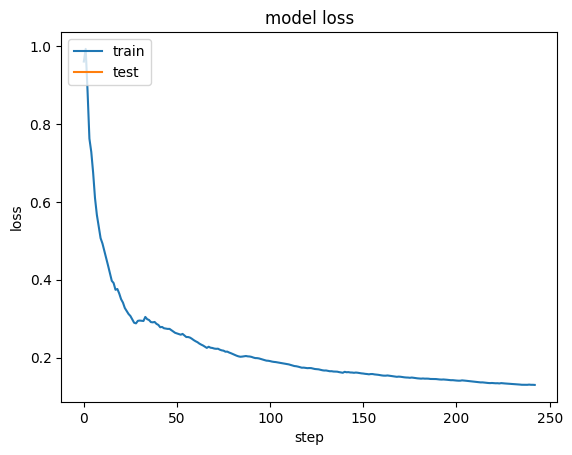

In [19]:
plt.plot(callback.losses)
plt.plot(callback.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('step')
plt.legend(['train', 'test'], loc='upper left')
plt.show()